# Flocking Simulation

This notebook serves as a conceptual validation model to the universe using the Viscek flocking model. To investigate the influence the emergence of collective behavior, we vary different parameters of the flocking model such as interaction radius, alignment strength, and noise level. The purpose is to use these results as a baseline comparison to validate the universe simulation.

Interaction radius refers to the threshold distance within which agents are considered neighbours.

Alignment strength refers to how strongly agents steer towards the average velocity of its neighbours.

Noise level refers to the amount of randomness that pushes/steers an agent away from perfect alignment. This represents turbulence, biological randomness, or imperfect sensing in real flocks.

Overall, the simulation investigates how these three parameters affect the fraction of agents in the largest cluster (LCF) and the average distance to the nearest neighbour in a flock (NN), providing quantitative insight into the structure and cohesion of the flock.


In [2]:
import os, sys
sys.path.append(os.path.abspath(".."))

import numpy as np
import matplotlib.pyplot as plt

from src.flocking_sim import run_simulation
from src.metrics import nearest_neighbor_distance, largest_cluster_fraction

#this makes it match universe notebook
box_size = 1.0
eps = 0.05
steps = 400
N = 200

os.makedirs(os.path.abspath("../figures"), exist_ok=True)

## Effects of Alignment Strength and Noise Levels on Fraction of Largest Cluster and Average Nearest Neighbour Distance

In this experiment, the alignment strength and noise level are systematically varied to examine their combined influence on collective flocking behavior. For each parameter pair, multiple simulation runs with different random seeds are performed to reduce stochastic variability.

To gain a holistic view of the model, we took the vaergae LCF and NN from the last 50 frames of each simulation. We also set the time step dt = 0.1 to prevent agents from overshooting their alignment. 

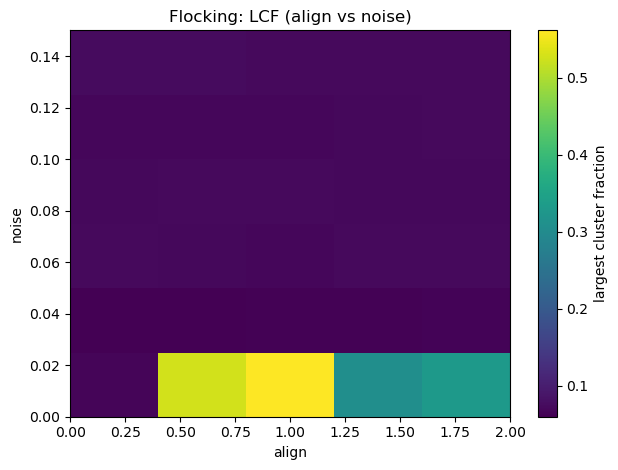

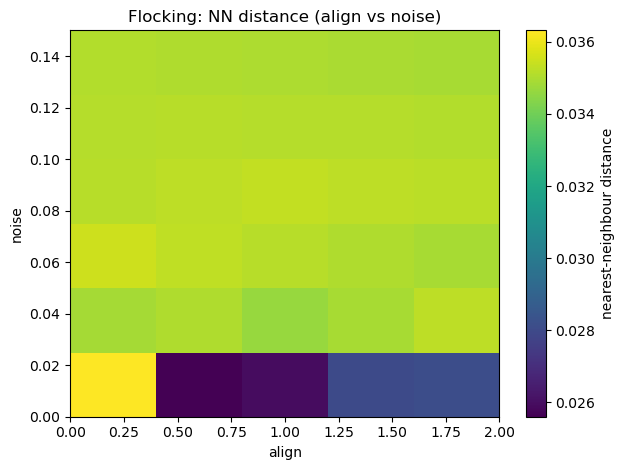

In [5]:
align_vals = [0.0, 0.5, 1.0, 1.5, 2.0]
noise_vals = [0.0, 0.03, 0.06, 0.09, 0.12, 0.15]

R = 3 * eps          
speed = 0.03
seeds = [0, 1, 2]   

LCF = np.zeros((len(noise_vals), len(align_vals)))
NN  = np.zeros_like(LCF)

K = 50   # number of final timesteps to average over

for i, noise in enumerate(noise_vals):
    for j, align in enumerate(align_vals):

        lcf_runs = []
        nn_runs = []

        for s in seeds:
            hist = run_simulation(
                N=N, steps=steps, box_size=box_size,
                align=align, noise=noise, R=R, speed=speed, dt=0.1,
                seed=s, save_every=1
            )

            # average over last K frames
            lcf_time = []
            nn_time = []

            for pos in hist[-K:]:
                lcf_time.append(largest_cluster_fraction(pos, eps=eps, box_size=box_size))
                nn_time.append(nearest_neighbor_distance(pos, box_size=box_size))

            lcf_runs.append(np.mean(lcf_time))
            nn_runs.append(np.mean(nn_time))

        LCF[i, j] = np.mean(lcf_runs)
        NN[i, j]  = np.mean(nn_runs)


#plot and save the LCF
plt.figure()
plt.imshow(LCF, origin="lower", aspect="auto",
           extent=[min(align_vals), max(align_vals), min(noise_vals), max(noise_vals)])
plt.colorbar(label="largest cluster fraction")
plt.xlabel("align")
plt.ylabel("noise")
plt.title("Flocking: LCF (align vs noise)")
plt.tight_layout()
plt.savefig("../figures/flock_align_noise_lcf.png", dpi=200)
plt.show()

# plot adn save the NN
plt.figure()
plt.imshow(NN, origin="lower", aspect="auto",
           extent=[min(align_vals), max(align_vals), min(noise_vals), max(noise_vals)])
plt.colorbar(label="nearest-neighbour distance")
plt.xlabel("align")
plt.ylabel("noise")
plt.title("Flocking: NN distance (align vs noise)")
plt.tight_layout()
plt.savefig("../figures/flock_align_noise_nn.png", dpi=200)
plt.show()

The heatmaps show that both local compactness (NN) and global cohesion (LCF) are maximized at moderate alignment strengths and low noise levels. When alignment is weak, agents fail to coordinate, resulting in dispersed motion. Increasing alignment initially promotes tight clustering and the formation of a dominant flock. However, at very high alignment strengths, both NN and LCF deteriorate slightly, indicating reduced stability due to over-correction in the discrete alignment update. Increasing noise consistently suppresses both metrics, demonstrating its role as a disordering mechanism that prevents sustained collective behavior.

## Effects of Interaction Radius and Noise Levels on Fraction of Largest Cluster and Average Nearest Neighbour Distance

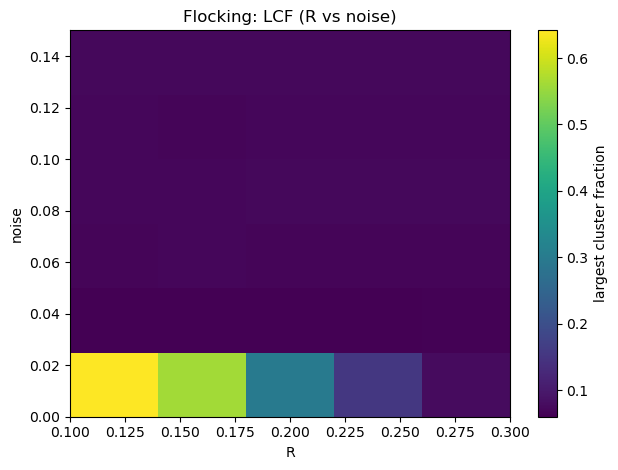

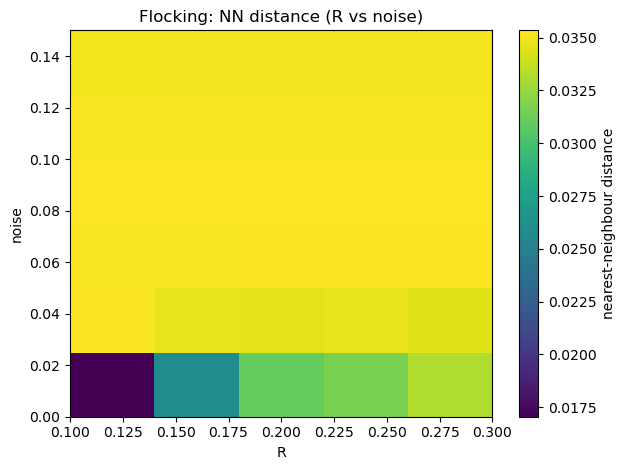

In [7]:
R_vals = [2*eps, 3*eps, 4*eps, 5*eps, 6*eps]   # 0.10 to 0.30
noise_vals = [0.0, 0.03, 0.06, 0.09, 0.12, 0.15]

align = 1.0
speed = 0.03
seeds = [0, 1, 2]

LCF2 = np.zeros((len(noise_vals), len(R_vals)))
NN2 = np.zeros_like(LCF2)

K = 50   # number of final timesteps to average over

for i, noise in enumerate(noise_vals):
    for j, R in enumerate(R_vals):

        lcf_runs = []
        nn_runs = []

        for s in seeds:
            hist = run_simulation(
                N=N, steps=steps, box_size=box_size,
                align=align, noise=noise, R=R, speed=speed, dt=0.1,
                seed=s, save_every=1
            )

            # average over last K frames
            lcf_time = []
            nn_time = []

            for pos in hist[-K:]:
                lcf_time.append(largest_cluster_fraction(pos, eps=eps, box_size=box_size))
                nn_time.append(nearest_neighbor_distance(pos, box_size=box_size))

            lcf_runs.append(np.mean(lcf_time))
            nn_runs.append(np.mean(nn_time))

        LCF2[i, j] = np.mean(lcf_runs)
        NN2[i, j]  = np.mean(nn_runs)

plt.figure()
plt.imshow(LCF2, origin="lower", aspect="auto",
           extent=[min(R_vals), max(R_vals), min(noise_vals), max(noise_vals)])
plt.colorbar(label="largest cluster fraction")
plt.xlabel("R")
plt.ylabel("noise")
plt.title("Flocking: LCF (R vs noise)")
plt.tight_layout()
plt.savefig("../figures/flock_R_noise_lcf.png", dpi=200)
plt.show()


plt.figure()
plt.imshow(NN2, origin="lower", aspect="auto",
           extent=[min(R_vals), max(R_vals), min(noise_vals), max(noise_vals)])
plt.colorbar(label="nearest-neighbour distance")
plt.xlabel("R")
plt.ylabel("noise")
plt.title("Flocking: NN distance (R vs noise)")
plt.tight_layout()
plt.savefig("../figures/flock_R_noise_nn.png", dpi=200)
plt.show()

## Effect of Interaction Radius and Noise on Collective Behavior

The following heatmaps show how the interaction radius (R) and noise level jointly affect the structure of the flock.

The first heatmap visualizes the **Largest Cluster Fraction (LCF)**, which measures the proportion of agents belonging to the largest coherent group.  
The second heatmap shows the **Nearest Neighbour Distance (NN)**, which captures local compactness within the flock.

From the results, we observe that:

- At **low noise levels**, increasing the interaction radius leads to stronger clustering, as agents can align with more neighbors.
- As **noise increases**, both LCF and NN deteriorate, indicating a breakdown of collective behavior.
- Even with a large interaction radius, high noise prevents the formation of stable flocks.
- The strongest collective behavior emerges in the regime of **moderate interaction radius and low noise**, where agents can coordinate without being dominated by randomness.

These results highlight the trade-off between interaction range and stochasticity, and show that global order emerges only within a limited region of parameter space.

## Parameter Sensitivity Analysis Using Line Plots

While the heatmaps provide a global overview of system behavior, they can obscure detailed trends along individual dimensions.  
To address this, we plot the largest cluster fraction (LCF) while varying one parameter at a time and keeping the others fixed.

This analysis helps identify:
- How sensitive collective behavior is to noise
- Whether there exists an optimal alignment strength
- How interaction radius influences stability under different noise levels

In [ ]:
R_vals = [2*eps, 3*eps, 4*eps, 5*eps, 6*eps]   # 0.10 to 0.30
align_vals = [0.0, 0.5, 1.0, 1.5, 2.0]

noise = 0.0
speed = 0.03
seeds = [0, 1, 2]

LCF3 = np.zeros((len(R_vals), len(align_vals)))
NN3 = np.zeros_like(LCF3)

K = 50   # number of final timesteps to average over

for i, R in enumerate(R_vals):
    for j, align in enumerate(align_vals):

        lcf_runs = []
        nn_runs = []

        for s in seeds:
            hist = run_simulation(
                N=N, steps=steps, box_size=box_size,
                align=align, noise=noise, R=R, speed=speed, dt=0.1,
                seed=s, save_every=1
            )

            # average over last K frames
            lcf_time = []
            nn_time = []

            for pos in hist[-K:]:
                lcf_time.append(largest_cluster_fraction(pos, eps=eps, box_size=box_size))
                nn_time.append(nearest_neighbor_distance(pos, box_size=box_size))

            lcf_runs.append(np.mean(lcf_time))
            nn_runs.append(np.mean(nn_time))

        LCF3[i, j] = np.mean(lcf_runs)
        NN3[i, j]  = np.mean(nn_runs)

plt.figure()
plt.imshow(LCF3, origin="lower", aspect="auto",
           extent=[min(align_vals), max(align_vals), min(R_vals), max(R_vals)])
plt.colorbar(label="largest cluster fraction")
plt.xlabel("R")
plt.ylabel("align")
plt.title("Flocking: LCF (R vs align)")
plt.tight_layout()
plt.savefig("../figures/flock_R_align_lcf.png", dpi=200)
plt.show()


plt.figure()
plt.imshow(NN3, origin="lower", aspect="auto",
           extent=[min(R_vals), max(R_vals), min(align_vals), max(align_vals)])
plt.colorbar(label="nearest-neighbour distance")
plt.xlabel("R")
plt.ylabel("align")
plt.title("Flocking: NN distance (R vs align)")
plt.tight_layout()
plt.savefig("../figures/flock_R_align_nn.png", dpi=200)
plt.show()

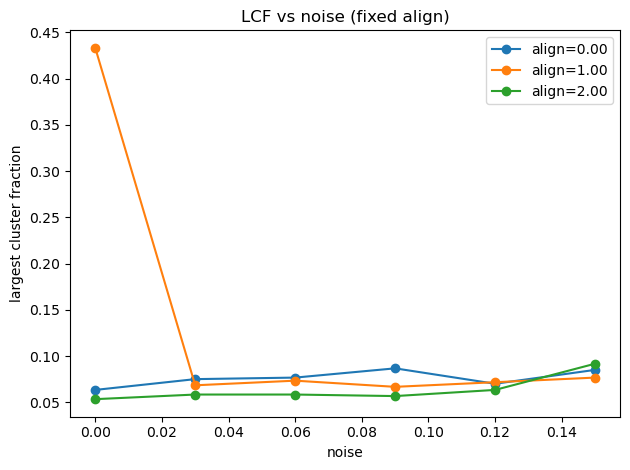

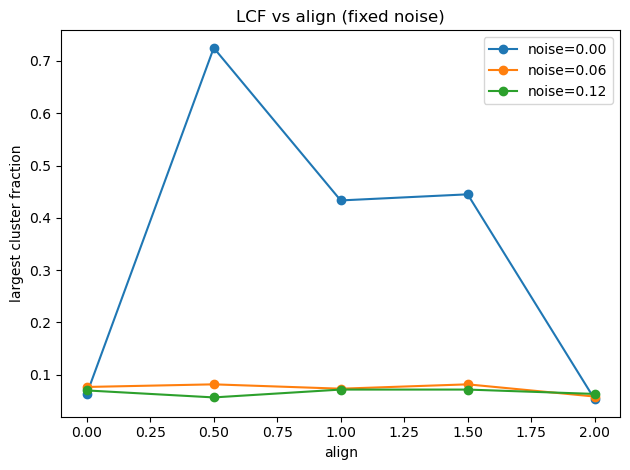

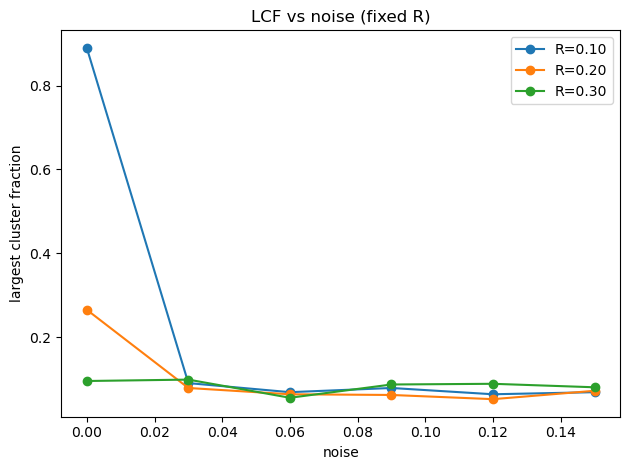

In [6]:
def nearest_index(values, target):
    values = np.array(values, dtype=float)
    return int(np.argmin(np.abs(values - target)))

align_vals_np = np.array(align_vals, dtype=float)
noise_vals_np = np.array(noise_vals, dtype=float)


# 1) LCF vs noise for fixed align
plt.figure()
for a_pick in [0.0, 1.0, 2.0]:
    j = nearest_index(align_vals_np, a_pick)
    plt.plot(noise_vals_np, LCF[:, j], marker="o", label=f"align={align_vals_np[j]:.2f}")
plt.xlabel("noise")
plt.ylabel("largest cluster fraction")
plt.title("LCF vs noise (fixed align)")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/line_lcf_vs_noise_fixed_align.png", dpi=200)
plt.show()



# 2) LCF vs align for fixed noise
plt.figure()
for n_pick in [0.0, 0.06, 0.12]:
    i = nearest_index(noise_vals_np, n_pick)
    plt.plot(align_vals_np, LCF[i, :], marker="o", label=f"noise={noise_vals_np[i]:.2f}")
plt.xlabel("align")
plt.ylabel("largest cluster fraction")
plt.title("LCF vs align (fixed noise)")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/line_lcf_vs_align_fixed_noise.png", dpi=200)
plt.show()



# 3) LCF vs noise for fixed R
R_vals_np = np.array(R_vals, dtype=float)

plt.figure()
for R_pick in [R_vals_np[0], R_vals_np[len(R_vals_np)//2], R_vals_np[-1]]:
    j = nearest_index(R_vals_np, R_pick)
    plt.plot(noise_vals_np, LCF2[:, j], marker="o", label=f"R={R_vals_np[j]:.2f}")
plt.xlabel("noise")
plt.ylabel("largest cluster fraction")
plt.title("LCF vs noise (fixed R)")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/line_lcf_vs_noise_fixed_R.png", dpi=200)
plt.show()

## Line plots (LCF sensitivity checks)

To make the heatmap patterns easier to read, we also plot LCF as a function of one parameter while keeping the other parameter fixed.  
Here, **LCF (largest cluster fraction)** measures how much of the flock ends up in one dominant coherent group.

### 1) LCF vs noise (fixed alignment)

- For **align = 1.0**, we see a very high LCF at **noise = 0.00** (around **0.43**), but it immediately drops to roughly **0.07** once noise increases to **0.03** and stays low afterwards.
- For **align = 0.0** and **align = 2.0**, LCF stays low across all noise values (mostly around **0.05–0.09**).

This suggests that **perfectly noiseless conditions** can sometimes allow a large coherent cluster to form (especially at align = 1.0), but even a small amount of noise quickly breaks that global structure.

### 2) LCF vs alignment (fixed noise)

- When **noise = 0.00**, LCF becomes very large at **align = 0.5** (around **0.73**), and remains relatively high around **align = 1.0–1.5** (around **0.43–0.45**), but then collapses again at **align = 2.0** (close to **0.05**).
- When **noise = 0.06** or **noise = 0.12**, LCF stays low (about **0.06–0.08**) for all alignment values.

So, in a noiseless setting, there seems to be an “optimal” alignment range that supports a dominant flock, but **with moderate noise**, alignment alone is not enough to sustain a large coherent cluster.

### 3) LCF vs noise (fixed interaction radius R)

- At **noise = 0.00**, LCF is extremely high for **R = 0.10** (around **0.90**), and still noticeably higher for **R = 0.20** (around **0.27**) compared to **R = 0.30** (around **0.10**).
- Once noise increases to **0.03**, all three curves drop to roughly **0.08–0.11** and remain fairly flat afterwards.

This again shows that **even small noise strongly suppresses global flock formation**. The very large values at noise = 0.00 likely reflect a “best-case” regime where the system can lock into a single large cluster, but this behavior is fragile and disappears once randomness is introduced.

Overall, these line plots support the main message from the heatmaps: **strong collective structure only emerges in a limited parameter regime, and noise is a dominant factor that destroys global order.**